<a href="https://colab.research.google.com/github/victoriousvictor42/Sales-Forecasting/blob/main/Sales_Forecasting_Using_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Time Series Forecating


---

## Objective
Forecast the next 12 months of product sales using time series models to identify trends, seasonality, and improve business planning.


---

## Delivarables


*   Time series decomposition - trend, seasonality, residuals
*   Modeling - ARIMA, Prophet, or LSTM
*   Evaluation metrics - MAE, RMSE
*   Forecast visualization - Line plots, confidence intervals







## 2. Import libraries

In [3]:
%pip install statsmodels prophet statsforecast --quiet --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.0 MB/s eta 0:00:00


In [4]:
# importing basic libraries for daa handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for decomposing timeseries into trend, seasonality, residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# forecasting library (AutoARIMA, SARIMA, etc)
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Prophet model for time series forecasting
from prophet import Prophet

# Evaluation metrics to measure forecasting accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

## 3. Generate Synthetic Sales Data

Since we don't use real sales data here, we generate a synthetic dataset for this dataset. This creates a realistic-looking sales time series with both randomness and trend.

---
### 3.1 Synthetic Data Generation


*   pd.date_range → Creates a monthly date range starting from January 2020 with 36 periods (3 years)
*   np.random.poisson → Simulates random sales values around a mean (λ=200)
*   np.linspace(0,100,36) → Adds a small upward trend over time
*   pd.DataFrame → Combines the dates and sales into a clean dataset







In [5]:
# Generate a date range of 36 months starting from Jan 2020
date_range = pd.date_range(start='2020-01-01',periods=36,freq='M')

# Create synthetic sales data with a base Poisson Distribution + upward trend
sales = np.random.poisson(lam=200,size=36) + np.linspace(0,100,36)

# Build Dataframe with Date and Sales values
df = pd.DataFrame({'Date':date_range,'Sales':sales.round(2)})


In [6]:
# Preview the first 5 rows
df.head()

,Date,Sales
0,2020-01-31,217.00
1,2020-02-29,208.86
2,2020-03-31,197.71
3,2020-04-30,184.57
4,2020-05-31,216.43


In [7]:
# Preview the last 5 rows
df.tail()

,Date,Sales
31,2022-08-31,266.57
32,2022-09-30,313.43
33,2022-10-31,284.29
34,2022-11-30,306.14
35,2022-12-31,315.00


In [8]:
df.shape

(36, 2)

there are 36 rows and 2 columns

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    36 non-null     datetime64[ns]
 1   Sales   36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.0 bytes


In [10]:
# Summary statistics
df.describe()

,Date,Sales
count,36,36.000000
mean,2021-07-15 21:20:00,251.694444
min,2020-01-31 00:00:00,184.570000
25%,2020-10-23 06:00:00,234.710000
50%,2021-07-15 12:00:00,248.715000
75%,2022-04-07 12:00:00,273.072500
max,2022-12-31 00:00:00,315.000000
std,NaN,33.271002


## 4. Exploratory Data Analysis (EDA)

We perform EDA to understand our synthetic sales dataset and identify trends, seasonality, and anomalies.

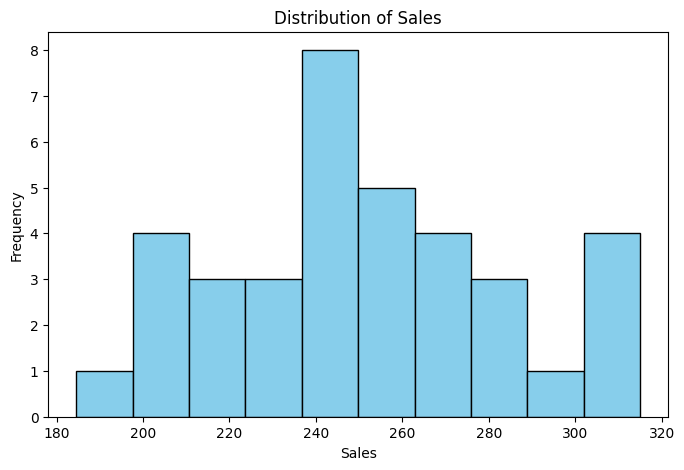

In [11]:
# Set figure size for the histogram
plt.figure(figsize=(8,5))

# Plot histogram of sales to visualize the distribution
plt.hist(df['Sales'],bins=10, color='skyblue', edgecolor='black')

# Add title and axis labels
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Display the plot
plt.show()

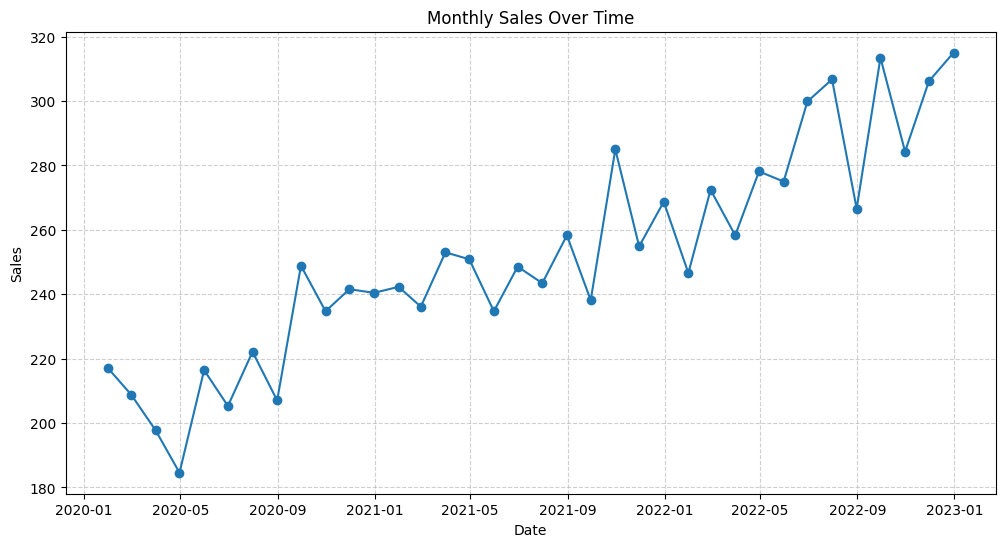

In [12]:
# Set figure size for the line plot
plt.figure(figsize=(12,6))

# Plot monthly sales over time with markers
plt.plot(df['Date'],df['Sales'],marker='o',linestyle='-')

# Add title and axis labels
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add grid for better readability
plt.grid(True,linestyle="--",alpha=0.6)

# Display the plot
plt.show()

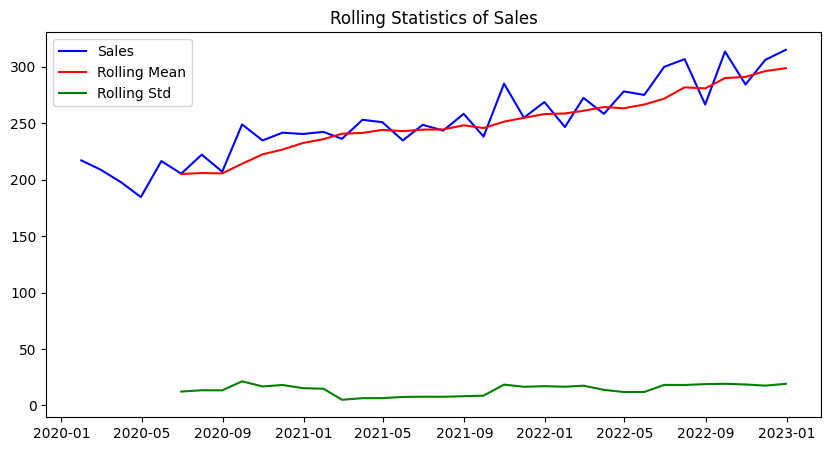

In [13]:
# calculate 6-month rolling mean and standard deviation
df_roll = df.copy()
df_roll['Rolling_Mean'] = df['Sales'].rolling(window=6).mean()
df_roll['RollingStd'] = df['Sales'].rolling(window=6).std()

# Set figure size for the plot
plt.figure(figsize=(10,5))

# Plot original sales, rolling mean, and rolling standard deviation
plt.plot(df['Date'], df['Sales'], label='Sales', color='blue')
plt.plot(df_roll['Date'], df_roll['Rolling_Mean'], label='Rolling Mean', color='red')
plt.plot(df_roll['Date'], df_roll['RollingStd'], label='Rolling Std', color='green')

# add legend and title
plt.legend()
plt.title('Rolling Statistics of Sales')

# Display the plot
plt.show()

Seasonal Decomposition helps us understand underlying patterns:


*   Trend → overall direction of sales
*   Seasonality → repeating yearly patterns
*   Residuals → random noise in the series





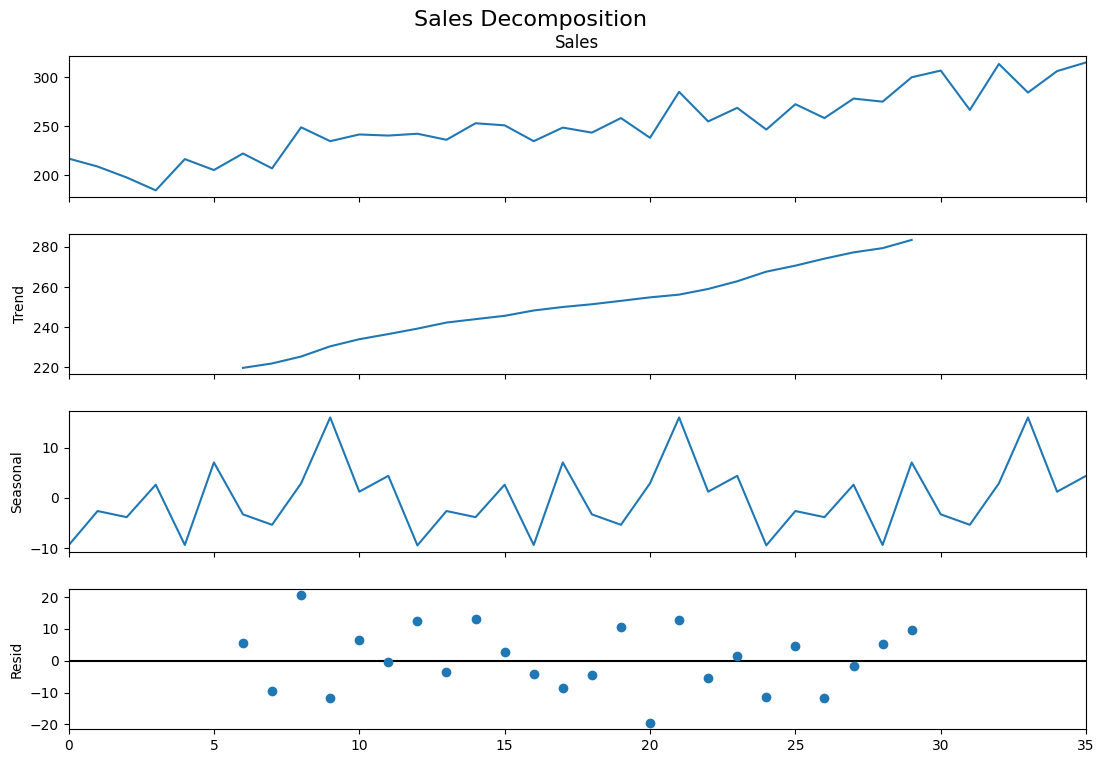

In [14]:
# Decompose the sales time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(df['Sales'], model='additive', period=12)

# Plot the decomposition components
fig = decomposition.plot()
fig.set_size_inches(12,8)

# Add a main title for the decomposition plot
plt.suptitle("Sales Decomposition", fontsize=16)

# Display the plot
plt.show()

## 5. Model Training and Forecasting

In this step, we prepare the dataset and train AutoARIMA and Prophet models to forecast sales for the next 12 months. This allows us to analyze trends and compare model performance.

In [ ]:
# Sp